In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "64" # for jupyter.nersc.gov otherwise the notebook only uses 2 cores

In [2]:
import healpy as hp
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
%matplotlib inline

In [3]:
hp.disable_warnings()

In [4]:
plt.style.use("seaborn-talk")

In [5]:
import pysm3 as pysm
import pysm3.units as u


In [6]:
nside = 2048
lmax = 2048
 

In [7]:
comp = "IQU"

In [8]:
components = list(enumerate(comp))
components

[(0, 'I'), (1, 'Q'), (2, 'U')]

In [9]:
spectra_components = ["TT", "EE", "BB"]

change this to True   if you want to  run namaster on notebook 


In [10]:
namaster_on_nb=False 

In [12]:
datadir='/global/cscratch1/sd/giuspugl/workstation/FG_extension/extending_gnilc_dust/'

planck_mask =  hp.read_map(datadir+ "HFI_Mask_GalPlane-apo2deg_2048_R2.00_GAL080.fits")


In [13]:
planck_mask= np.int_( np.ma.masked_not_equal(planck_mask ,  0. ).mask )
fsky= planck_mask.sum()/planck_mask.size 
print(f"masking {fsky} of the sky" )  

masking 0.7912631829579672 of the sky


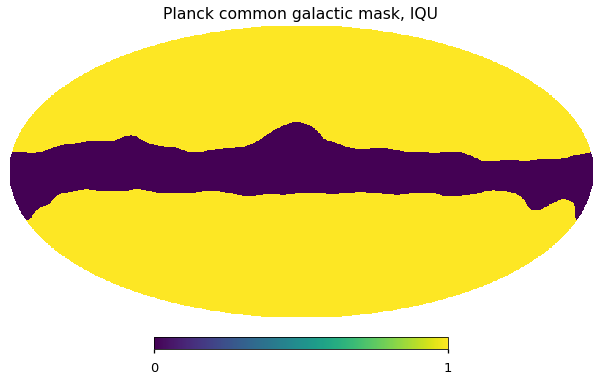

In [14]:
hp.mollview(   planck_mask  , title=f"Planck common galactic mask, {comp}")



## Dust maps 
- We use the GNILC intensity map from the 2nd planck release, as it encodes less contamination from CIB with variable resolutions 
- for Q and U we adopt maps from the 3rd Planck release as they were optimized for polarization studies with variable resolutions. 



In [15]:
dust_varresI = datadir+"COM_CompMap_Dust-GNILC-F353_2048_R2.00.fits"
dust_varresP= datadir+"COM_CompMap_IQU-thermaldust-gnilc-varres_2048_R3.00.fits"

In [16]:
m_planck_varres ,h = hp.read_map(dust_varresP , [c+"_STOKES" for c in comp], h=True)
I_planck_varres ,h = hp.read_map(dust_varresI , h=True)

Maps from the two releases are in different units `MJy/sr` the former, and `K_CMB` the latter, we therefore need to perform some conversion to `uK_RJ`. 

In [17]:
m_planck_varres <<= u.K_CMB 
I_planck_varres <<= (u. MJy/u.sr ) 
m_planck_varres = m_planck_varres.to("uK_RJ", equivalencies=u.cmb_equivalencies(353*u.GHz))
I_planck_varres = I_planck_varres.to("uK_RJ", equivalencies=u.cmb_equivalencies(353*u.GHz)) 

then we are ready to combine both maps into one single TQU map. 

In [18]:
m_planck_varres[0] = I_planck_varres.copy() 


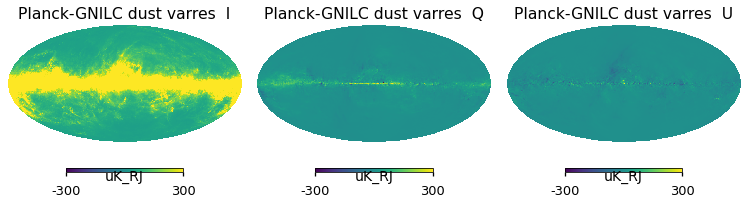

In [19]:
for i_pol, pol in components:
    hp.mollview(m_planck_varres[i_pol], title="Planck-GNILC dust varres  "+pol , sub=131+i_pol  , unit=m_planck_varres.unit, min=-300, max=300)
    
    

## Monopole subtraction  

we   estimate the monopole term from the map outside the galactic mask to have a rough estimate of the CIB monopole .
When removing the monopole we  noticed that:
- doing it before transforming to logarithmic pol. tensor results in NaN regions in correspondence of $I^2 - P^2 < 0 $ pixels  
- removing a monopole term in the pol.tensor transformed quantity $i,q,u$ is not correct as  when we transform back to real quantities the maps before and after transformation don't match . 
E.g. 
assume you subtract a constant term to $i$ , i.e. 
$$i' =i -c$$
then 
$$I'\neq I$$
since 
$$ I' = e^{i'} \cosh p  = e^{i-c}\cosh p  = e^{-c} I $$.  

In [20]:
mono, dip_vector = hp.fit_dipole(m_planck_varres[0][planck_mask])

In [21]:
print(" the estimated monopole is ",(mono  *u.uK_RJ).to("MJy/sr", equivalencies=u.cmb_equivalencies(353*u.GHz))  )

 the estimated monopole is  0.16440431369209324 MJy / sr


Section 2.2 of [Planck 2018 XII](https://arxiv.org/pdf/1807.06212.pdf) value reported:  0.13 MJy/sr 

we subtract this term only to the I map for   the pixels outside  the Galactic plane mask.

In [22]:
planck2018_monopole = (0.13*u.MJy/u.sr).to(u.uK_RJ, equivalencies=u.cmb_equivalencies(353*u.GHz) ) 

m_planck_varres[0][planck_mask]  -= planck2018_monopole 


In [23]:
maskmono =m_planck_varres [0]**2 < m_planck_varres[1]**2+m_planck_varres[2]**2
print(f"{maskmono.sum() } pixels out of { maskmono.size} expected to be NaNs in Log Pol Tens maps ")

4 pixels out of 50331648 expected to be NaNs in Log Pol Tens maps 


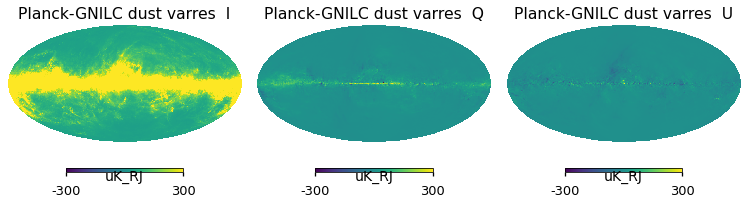

In [24]:
for i_pol, pol in components:
    hp.mollview(m_planck_varres[i_pol], title="Planck-GNILC dust varres  "+pol , sub=131+i_pol  , unit=m_planck_varres.unit, min=-300, max=300)
    
    

In [284]:
if not os.path.exists(datadir+'dust_gnilc_varres_no_monopole.fits') : 
    
    hp.write_map(datadir+"dust_gnilc_varres_no_monopole.fits", m_planck_varres   )

## Transform maps to Poltens quantities 

In [25]:
import numpy as np
import healpy as hp



def map_to_log_pol_tens(m):
    P = np.sqrt(m[1] ** 2 + m[2] ** 2)
    log_pol_tens = np.empty_like(m)
    log_pol_tens[0] = np.log(m[0] ** 2 - P ** 2) / 2.0
    log_pol_tens[1:] = m[1:] / P * np.log((m[0] + P) / (m[0] - P)) / 2.0
    return log_pol_tens


def log_pol_tens_to_map(log_pol_tens):
    P = np.sqrt(log_pol_tens[1] ** 2 + log_pol_tens[2] ** 2)
    m = np.empty_like(log_pol_tens)
    exp_i =np.exp(log_pol_tens[0])
    m[0] = exp_i * np.cosh(P)
    m[1:] = log_pol_tens[1:] / P * exp_i * np.sinh(P)
    return m


def sigmoid(x, x0, width, power=4):
    """Sigmoid function given start point and width
    Parameters
    ----------
    x : array
        input x axis
    x0 : float
        value of x where the sigmoid starts (not the center)
    width : float
        width of the transition region in unit of x
    power : float
        tweak the steepness of the curve
    Returns
    -------
    sigmoid : array
        sigmoid, same length of x"""
    return 1.0 / (1 + np.exp(-power * (x - x0 - width / 2) / width))
    # return np.heaviside(x - x0, 0)
    #fwhm = 20 * u.arcmin
    #return 1 - hp.gauss_beam(fwhm=fwhm.to_value(u.radian), lmax=x[-1])**2

In [26]:
log_pol_tens_varres = map_to_log_pol_tens(m_planck_varres .value)

<ipython-input-25-18e0cc75e7ff>:9: RuntimeWarning: invalid value encountered in log
  log_pol_tens[0] = np.log(m[0] ** 2 - P ** 2) / 2.0
<ipython-input-25-18e0cc75e7ff>:10: RuntimeWarning: invalid value encountered in log
  log_pol_tens[1:] = m[1:] / P * np.log((m[0] + P) / (m[0] - P)) / 2.0


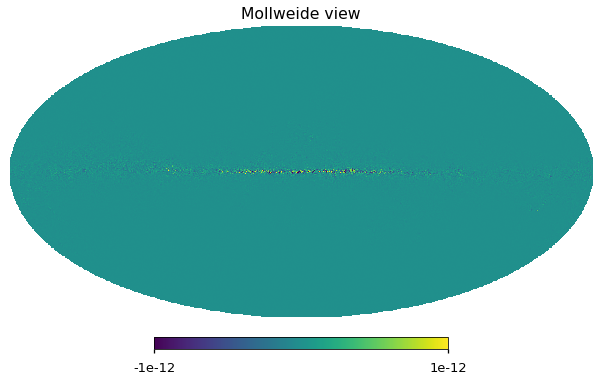

In [27]:
m_back   = log_pol_tens_to_map(log_pol_tens_varres ) 
hp.mollview( (m_planck_varres.value  - m_back )[1], min=-1e-12,max=1e-12 )
del m_back 

In [28]:
print(f"{np.isnan(log_pol_tens_varres).sum()  } pixels out of { maskmono.size} are NaNs in Log Pol Tens maps ")

12 pixels out of 50331648 are NaNs in Log Pol Tens maps 


In [29]:
for i in range(3):
    log_pol_tens_varres [i, np.isnan(log_pol_tens_varres[i])] = np.nanmedian(log_pol_tens_varres[i])

In [30]:
assert np.isnan(log_pol_tens_varres).sum() == 0

In [84]:
if not os.path.exists(datadir+"dust_gnilc_logpoltens_varres_nomono.fits") : 
    hp.write_map(datadir+"dust_gnilc_logpoltens_varres_nomono.fits", log_pol_tens_varres)

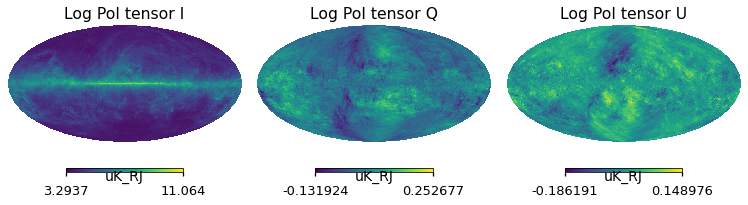

In [34]:
for i_pol, pol in components:
    hp.mollview(log_pol_tens_varres[i_pol], title="Log Pol tensor "+pol , sub=131+i_pol  , unit= m_planck_varres.unit)

In [35]:
from scipy.optimize import curve_fit

In [36]:
def model(ell, A, gamma):
    out = A * ell ** gamma
    out[:2] = 0
    return out

In [37]:
def run_anafast(m, lmax) : 
    clanaf=hp.anafast(m , lmax=lmax ) 
    cl ={} 
    cl["TT"] = clanaf[0]
    cl["EE"] = clanaf[1]
    cl["BB"] = clanaf[2 ]
    ell = np.arange(lmax +1 ) 
    
    cl_norm = ell * (ell + 1) / np.pi / 2
    cl_norm[0] = 1
    return ell,cl_norm, cl     



def run_namaster(m, mask, lmax):
    """Compute C_ell with NaMaster
    Parameters
    ----------
    m : numpy array
        T only or TQU HEALPix map
    mask : numpy array
        mask, 1D, 0 for masked pixels,
        needs to have same Nside of the input map
    lmax : int
        maximum ell of the spherical harmonics transform
    Returns
    -------
    ell : numpy array
        array of ell from 0 to lmax (length lmax+1)
    cl_norm : numpy array
        ell (ell+1)/2pi factor to turn C_ell into D_ell
        first element is set to 1
    cl : dict of numpy arrays
        dictionary of numpy arrays with all components
        of the spectra, for now only II, EE, BB, no
        cross-spectra
    """
    nside = hp.npix2nside(len(mask))

    binning = nmt.NmtBin(nside=nside, nlb=1, lmax=lmax, is_Dell=False)

    cl = {}

    f_0 = nmt.NmtField(mask, [m[0] ])

    if len(m) == 3:
        f_2 = nmt.NmtField(mask, m[1:].copy())  # NaMaster masks the map in-place
        cl_namaster = nmt.compute_full_master(f_2, f_2, binning)
        cl["EE"] = np.concatenate([[0, 0], cl_namaster[0]])
        cl["BB"] = np.concatenate([[0, 0], cl_namaster[3]])
        cl_namaster = nmt.compute_full_master(f_0, f_2, binning)
        cl["TE"] = np.concatenate([[0, 0], cl_namaster[0]])
    elif m.ndim == 1:
        m = m.reshape((1, -1))

    cl_namaster_I = nmt.compute_full_master(f_0, f_0, binning)

    cl["TT"] = np.concatenate([[0, 0], cl_namaster_I[0]])
    ell = np.concatenate([[0, 1], binning.get_effective_ells()])
    cl_norm = ell * (ell + 1) / np.pi / 2
    cl_norm[0] = 1
    return ell, cl_norm, cl

In [38]:

fspectra=datadir+"cl_dust_gnilc_logpoltens_varres_nomono.npz"
if   os.path.exists(fspectra): 
    print("read Namaster spectra  ")
    ell =np.load(fspectra)['ell']
    cl_norm =np.load(fspectra)['cl_norm']
    cl ={kk : np.load(fspectra )[kk]  for kk in spectra_components } 
elif namaster_on_nb : 
    print("run Namaster  ")
    ell,cl_norm,cl = run_namaster(log_pol_tens_varres, lmax=lmax )
else : 
    print ("run anafast on masked sky  ")
    ell,cl_norm,cl=run_anafast(log_pol_tens_varres,lmax)    
    


read Namaster spectra  


<ipython-input-39-2cb1e28736e8>:31: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim(0, lmax)
<ipython-input-39-2cb1e28736e8>:31: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim(0, lmax)
<ipython-input-39-2cb1e28736e8>:31: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim(0, lmax)


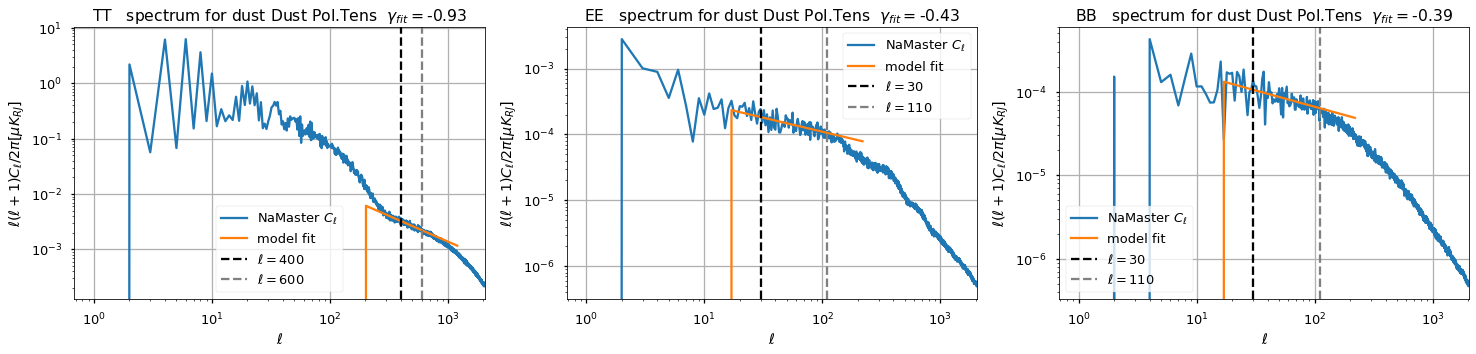

In [39]:
ell_fit_low = {"TT":400, "EE":30, "BB":30}
ell_fit_high = {"TT":600, "EE":110, "BB":110}
A_fit, gamma_fit, A_fit_std, gamma_fit_std = {},{},{},{}
plt.figure(figsize=(25,5))

for ii, pol in enumerate(spectra_components):
    plt.subplot(131+ii)
    xdata = np.arange(ell_fit_low[pol], ell_fit_high[pol])
    ydata = xdata*(xdata+1)/np.pi/2 * cl[pol][xdata]
    (A_fit[pol], gamma_fit[pol]), cov = curve_fit(model, xdata, ydata)

    A_fit_std[pol], gamma_fit_std[pol] = np.sqrt(np.diag(cov))
    plt.loglog(ell, ell*(ell+1)/np.pi/2 * cl[pol], label="NaMaster $C_\ell$")
    #plt.loglog(ell, ell*(ell+1)/np.pi/2 * cl1[pol] , label="Anafast $C_\ell$")
    # plt.semilogx(ell, ell*(ell+1)/np.pi/2 * cl[pol], label="NaMaster $C_\ell smoothed$")
    # plt.loglog(ell, ell*(ell+1)/np.pi/2 * cl_sigma_G[pol], label="SS $C_\ell$")

    plt.plot(ell[ell_fit_low[pol]//2:ell_fit_high[pol]*2], 
             model(ell[ell_fit_low[pol]//2:ell_fit_high[pol]*2], A_fit[pol], gamma_fit[pol]), label="model fit")
    
    #plt.plot(w_ell**2,  label=f"Beam {c} $C_\ell$")

    plt.axvline(ell_fit_low[pol], linestyle="--", color="black", label="$ \ell={} $".format(ell_fit_low[pol]))
    plt.axvline(ell_fit_high[pol], linestyle="--", color="gray", label="$ \ell={} $".format(ell_fit_high[pol]))
    plt.legend()
    plt.grid()
    plt.title(f"{pol}   spectrum for dust Dust Pol.Tens  "+r"$\gamma_{fit}=$"+f"{gamma_fit[pol]:.2f}")

    plt.ylabel("$\ell(\ell+1)C_\ell/2\pi [\mu K_{RJ}]$")
    plt.xlabel(("$\ell$"))
    plt.xlim(0, lmax)
    #plt.ylim(1, 30);
    #plt.xlim(ell_fit_low[pol]//2, lmax)
    #plt.ylim(0, 1e1 if pol == "TT" else 1e-3)


## making   Gaussian small scales   

In [40]:
np.random.seed(777)
zeros = np.zeros(len(ell), dtype=np.double)


In [41]:
print( A_fit , gamma_fit )
small_scales_input_cl = [
    1 \
    * model(ell, A_fit[pol], gamma_fit[pol]) \
    * sigmoid(ell, ell_fit_high[pol], ell_fit_high[pol]/10)  \
    / cl_norm \
    for pol in spectra_components
]

{'TT': 0.8504766509057815, 'EE': 0.0007804752377929203, 'BB': 0.00039867683802987264} {'TT': -0.9295232995987469, 'EE': -0.42552928216628133, 'BB': -0.38961457655585974}


<ipython-input-36-e2b761b15d12>:2: RuntimeWarning: divide by zero encountered in power
  out = A * ell ** gamma


In [42]:
alm_ss = hp.synalm(small_scales_input_cl + [zeros, zeros, zeros], new=True ) 


In [43]:
alm_log_pol_tens_fullsky = hp.map2alm(log_pol_tens_varres  , lmax=lmax, use_pixel_weights=True)

In [44]:
almfiltered=np.empty_like(alm_log_pol_tens_fullsky)
for ii, pol in enumerate(spectra_components ):
    sigmoid_pol = np.sqrt(1-sigmoid(ell, x0= ell_fit_high[pol], width= ell_fit_high[pol]/10))
    almfiltered[ii] = hp.almxfl(alm_log_pol_tens_fullsky[ii], sigmoid_pol, inplace=False )

# Making maps from alm 

Notice that the map encoding small gaussian scales and large  scales is obtained by the sum of the alm, instead of summing the two maps together (this shouldn't matter  as  inverse transform the alm to map is a linear process ) 


In [45]:
log_pol_tens_ls = hp.alm2map(almfiltered , nside=nside)   
log_pol_tens_ss = hp.alm2map(alm_ss , nside=nside)   
log_pol_tens_tot  = hp.alm2map(alm_ss+ almfiltered , nside=nside)   

In [46]:
assert np.allclose(log_pol_tens_tot, log_pol_tens_ls + log_pol_tens_ss )

In [47]:
get_p=lambda m : np.sqrt(m[1] **2 +m[2]**2 )  

pvarres = get_p( log_pol_tens_varres) 
ptot = get_p( log_pol_tens_tot)
pls = get_p( log_pol_tens_ls)
pss = get_p( log_pol_tens_ss)

In [50]:
out_tot = log_pol_tens_to_map(log_pol_tens_tot) 
out_ls = log_pol_tens_to_map(log_pol_tens_ls) 
out_ss = log_pol_tens_to_map(log_pol_tens_ss )  

We plot the maps in the pol tens formalism to see which term contribute the most    to the total map

in the following: 
- `LS` is the map encoding large-scales only 
- `SS` is the map encoding small-gaussian-scales only 
- `Varres` is the map obtained by transforming the GNILC maps to   Log Poltens quantities 


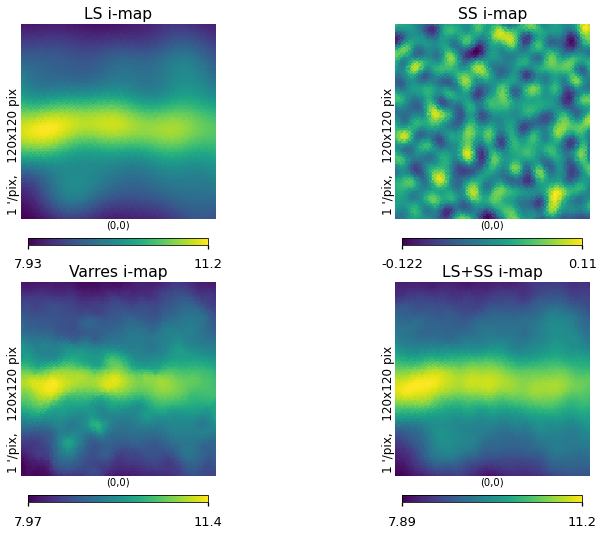

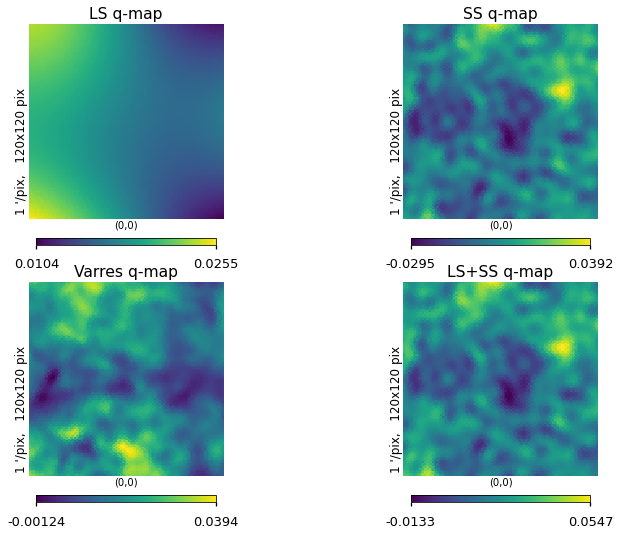

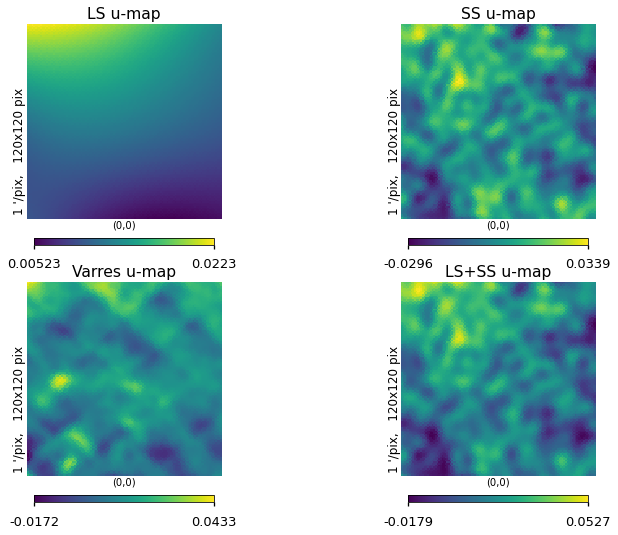

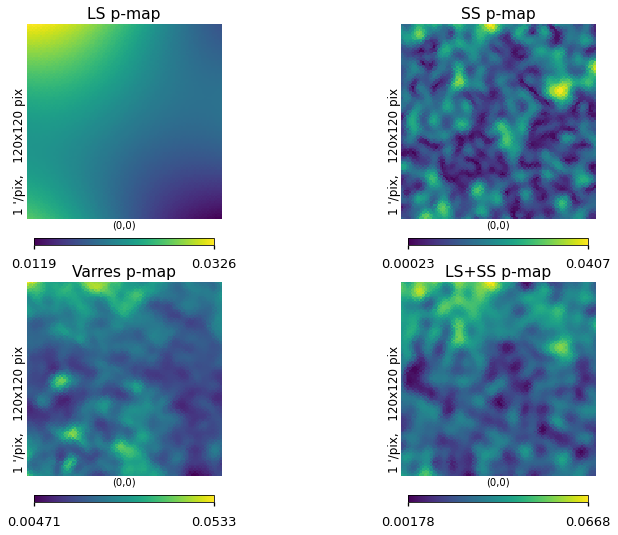

In [48]:
for i,pol  in  (components):
    
    if pol=='I': 
        ppol='i'
    elif pol=='Q':
        ppol='q'
    else :
        ppol='u'
    plt.figure() 
    hp.gnomview(log_pol_tens_varres[i],title=f"Varres {ppol}-map", sub=223, xsize=120, reso=1)
    hp.gnomview(log_pol_tens_tot[i],title=f"LS+SS {ppol}-map", sub=224, xsize=120, reso=1)
    hp.gnomview(log_pol_tens_ls[i],title=f"LS {ppol}-map", sub=221, xsize=120, reso=1)
    hp.gnomview(log_pol_tens_ss[i],title=f"SS {ppol}-map", sub=222, xsize=120, reso=1)

plt.figure() 
hp.gnomview(pvarres,title=f"Varres p-map", sub=223, xsize=120, reso=1)
hp.gnomview(ptot,title=f"LS+SS p-map", sub=224, xsize=120, reso=1)
hp.gnomview(pls,title=f"LS p-map", sub=221, xsize=120, reso=1)
hp.gnomview(pss ,title=f"SS p-map", sub=222, xsize=120, reso=1)

From the plot above we can notice several things: 

- the $i$ map is mostly driven by the map with  LS only, the ratio $i_{S}/i_{L}\sim \mathcal{O}(10^{-2})$ 
- the contribution of SS to $p$,  $q$ and $u$ maps instead is not negligible 
-  the ratio $p/i\sim  \mathcal{O}(10^{-3})$

We now use the transformation to real quantities to see what are the leading order quantities: 

$$
I = e^i \cosh p  = e^{i_S +i_L} \left( \frac{e^p + e^{-p} } {2} \right) \approx \frac{e^{ i_L}}{2}  \left(  ( e^{p/i_L})^{i_L}  + (e^{-p/i_L})^{i_L}    \right)$$
$$
 \approx \frac{e^{ i_L}}{2}  \left(  ( 1+  {p/i_L})^{i_L}  + (1 {-p/i_L})^{i_L}    \right)\approx \frac{e^{ i_L}}{2}  \left(  ( 1+  \frac{p}{i_L} i_L)   + (1 - \frac{p}{i_L}{i_L}  )  \right)\approx  e^{ i_L} $$
 
and similarly we find : 
$$
Q= \frac{q}{p} e^{i} \sinh p  \approx q e^{i_L} 
$$
and 
$$ 
U= \frac{u}{p} e^{i} \sinh p \approx u e^{i_L} 
$$


Let's check if those expression are actually good approximations of the back transformed maps ... 

We select a 5x5 deg patch far from the gal. plane $\ell,b= 0,50$

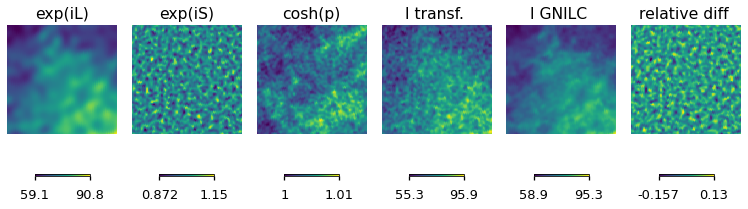

In [52]:

hp.gnomview(np.exp(log_pol_tens_ls[0]),  title='exp(iL)', rot=[0,50], sub=161, notext=True )
hp.gnomview(np.exp(log_pol_tens_ss[0]),  title='exp(iS)', rot=[0,50], sub=162, notext=True)
hp.gnomview(np.cosh(ptot),  title='cosh(p)', rot=[0,50], sub=163, notext=True)
hp.gnomview((out_tot[0]),  title='I transf. ', rot=[0,50],  sub=164, notext=True )
hp.gnomview((m_planck_varres[0]),  title='I GNILC ', rot=[0,50],  sub=165, notext=True )
hp.gnomview(((m_planck_varres[0].value) - out_tot[0])/m_planck_varres[0].value ,  
            title='relative diff ', rot=[0,50],  sub=166 , notext=True)

most of the dynamic range in the transformed quantity is set as expected by $e^{i_L}$ smaller contribution is given by $e^{i_S}$, whereas $\cosh p\approx 1$. the relative difference with the map GNILC is essentially due to the contribution in the small scales  

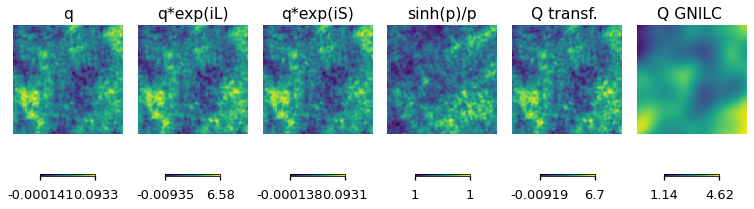

In [55]:
hp.gnomview(log_pol_tens_tot[1] ,  title='q', rot=[0,50], sub=161, notext=True)

hp.gnomview(log_pol_tens_tot[1] * np.exp(log_pol_tens_ls[0]),  title='q*exp(iL)', rot=[0,50], sub=162, notext=True )
hp.gnomview(log_pol_tens_tot[1] *np.exp(log_pol_tens_ss[0]),  title='q*exp(iS)', rot=[0,50], sub=163, notext=True)
hp.gnomview(np.sinh(ptot)/ptot,  title='sinh(p)/p', rot=[0,50], sub=164, notext=True)
hp.gnomview((out_tot[1]),  title='Q transf. ', rot=[0,50],  sub=165, notext=True )
hp.gnomview((m_planck_varres[1]),  title='Q GNILC ', rot=[0,50],  sub=166, notext=True )


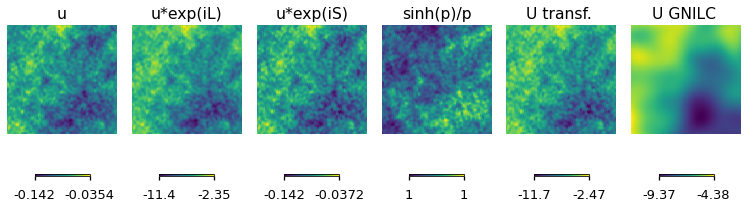

In [57]:

hp.gnomview(log_pol_tens_tot[2] ,  title='u', rot=[0,50], sub=161, notext=True)
hp.gnomview(log_pol_tens_tot[2] * np.exp(log_pol_tens_ls[0]),  title='u*exp(iL)', rot=[0,50], sub=162, notext=True )
hp.gnomview(log_pol_tens_tot[2] * np.exp(log_pol_tens_ss[0]),  title='u*exp(iS)', rot=[0,50], sub=163, notext=True )
hp.gnomview(np.sinh(ptot)/ptot,  title='sinh(p)/p', rot=[0,50], sub=164, notext=True)
hp.gnomview((out_tot[2]),  title='U transf. ', rot=[0,50],  sub=165, notext=True )
hp.gnomview((m_planck_varres[2]),  title='U GNILC ', rot=[0,50],  sub=166, notext=True )


for $Q$ and $U$ instead is  as expected the  combination of the respective logpol tens quantity with $e^{i_L}$ . 

We then check the power spectra 

In [51]:
hp.write_map(datadir+'newmaps/dust_gnilc_varres_poltens_ls.fits', log_pol_tens_ls)
hp.write_map(datadir+'newmaps/dust_gnilc_varres_poltens_tot.fits', log_pol_tens_tot)
hp.write_map(datadir+'newmaps/dust_gnilc_varres_poltens_ss.fits', log_pol_tens_ss)


In [53]:
hp.write_map(datadir+'newmaps/dust_gnilc_varres_ls.fits', out_ls)
hp.write_map(datadir+'newmaps/dust_gnilc_varres_tot.fits', out_tot)
hp.write_map(datadir+'newmaps/dust_gnilc_varres_ss.fits', out_ss)

In [58]:

fspectra=datadir+"newmaps/dust_gnilc_varres_poltens_ls_spectra.npz"
if   os.path.exists(fspectra): 
    print("read Namaster spectra  ")
    ell =np.load(fspectra)['ell']
    cl_norm =np.load(fspectra)['cl_norm']
    clLS ={kk : np.load(fspectra )[kk]  for kk in spectra_components } 


read Namaster spectra  


In [59]:

fspectra=datadir+"newmaps/dust_gnilc_varres_poltens_ss_spectra.npz"
if   os.path.exists(fspectra): 
    print("read Namaster spectra  ")
    ell =np.load(fspectra)['ell']
    cl_norm =np.load(fspectra)['cl_norm']
    clSS ={kk : np.load(fspectra )[kk]  for kk in spectra_components } 
 

read Namaster spectra  


In [60]:

fspectra=datadir+"newmaps/dust_gnilc_varres_poltens_tot_spectra.npz"
if   os.path.exists(fspectra): 
    print("read Namaster spectra  ")
    ell =np.load(fspectra)['ell']
    cl_norm =np.load(fspectra)['cl_norm']
    cltot ={kk : np.load(fspectra )[kk]  for kk in spectra_components } 
 

read Namaster spectra  


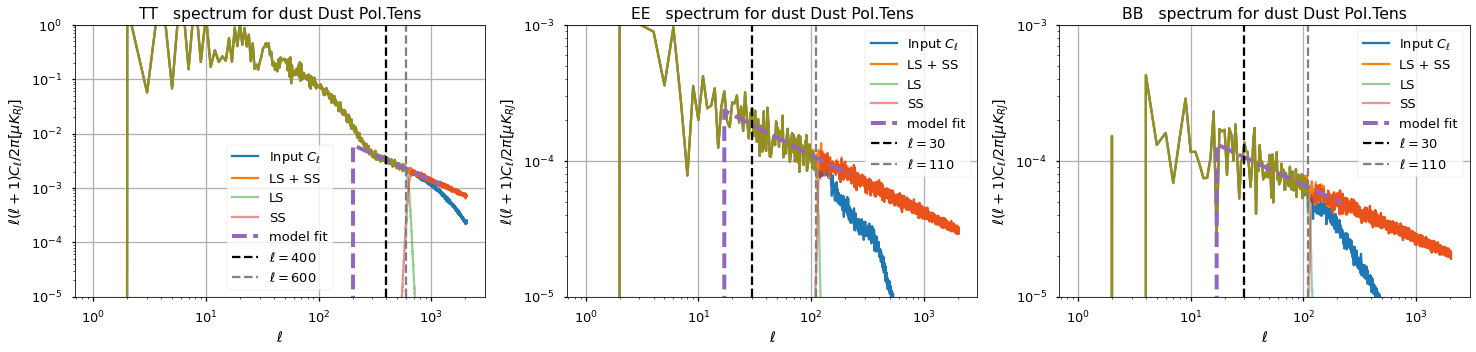

In [61]:
plt.figure(figsize=(25,5))


for ii, pol in enumerate(spectra_components):
    plt.subplot(131+ii)

    plt.loglog(ell, ell*(ell+1)/np.pi/2 * cl[pol], label="Input $C_\ell$")
    plt.plot(ell, ell*(ell+1)/np.pi/2 * cltot [pol],label='LS + SS ')
    plt.plot(ell, ell*(ell+1)/np.pi/2 * clLS  [pol]  ,label='LS',alpha=.5)
    plt.plot(ell, ell*(ell+1)/np.pi/2 * clSS  [pol]  ,label='SS',alpha=.5)
    
    plt.plot(ell[ell_fit_low[pol]//2:ell_fit_high[pol]*2], 
             model(ell[ell_fit_low[pol]//2:ell_fit_high[pol]*2], A_fit[pol], gamma_fit[pol]),lw=4,linestyle='--',  
             label="model fit")

    plt.axvline(ell_fit_low[pol], linestyle="--", color="black", label="$ \ell={} $".format(ell_fit_low[pol]))
    plt.axvline(ell_fit_high[pol], linestyle="--", color="gray", label="$ \ell={} $".format(ell_fit_high[pol]))
    plt.legend()
    plt.grid()
    plt.title(f"{pol}   spectrum for dust Dust Pol.Tens" )

    plt.ylabel("$\ell(\ell+1)C_\ell/2\pi [\mu K_{RJ}]$")
    plt.xlabel(("$\ell$"))
    #plt.xlim(30,800 )
    #plt.ylim(1, 30);
    #plt.xlim(ell_fit_low[pol]//2 +10 , lmax)
    plt.ylim(1e-5, 1e0 if pol == "TT" else 1e-3)


As already shown before, we don't see any mismatch in the logpol tens quantities


In [62]:

fspectra=datadir+"newmaps/dust_gnilc_varres_ss_spectra.npz"
if   os.path.exists(fspectra): 
    print("read Namaster spectra  ")
    ell =np.load(fspectra)['ell']
    cl_norm =np.load(fspectra)['cl_norm']
    clSSr ={kk : np.load(fspectra )[kk]  for kk in spectra_components } 
 

read Namaster spectra  


In [63]:

fspectra=datadir+"newmaps/dust_gnilc_varres_ls_spectra.npz"
if   os.path.exists(fspectra): 
    print("read Namaster spectra  ")
    ell =np.load(fspectra)['ell']
    cl_norm =np.load(fspectra)['cl_norm']
    clLSr ={kk : np.load(fspectra )[kk]  for kk in spectra_components } 
 

read Namaster spectra  


In [64]:

fspectra=datadir+"newmaps/dust_gnilc_varres_tot_spectra.npz"
if   os.path.exists(fspectra): 
    print("read Namaster spectra  ")
    ell =np.load(fspectra)['ell']
    cl_norm =np.load(fspectra)['cl_norm']
    cloutr ={kk : np.load(fspectra )[kk]  for kk in spectra_components } 


read Namaster spectra  


In [65]:
fspectra=datadir+"cl_dust_gnilc_varres_no_monopole.npz"
if   os.path.exists(fspectra): 
    print("read Namaster spectra  ")
    ell =np.load(fspectra)['ell']
    cl_norm =np.load(fspectra)['cl_norm']
    clin ={kk : np.load(fspectra )[kk]  for kk in spectra_components } 

read Namaster spectra  


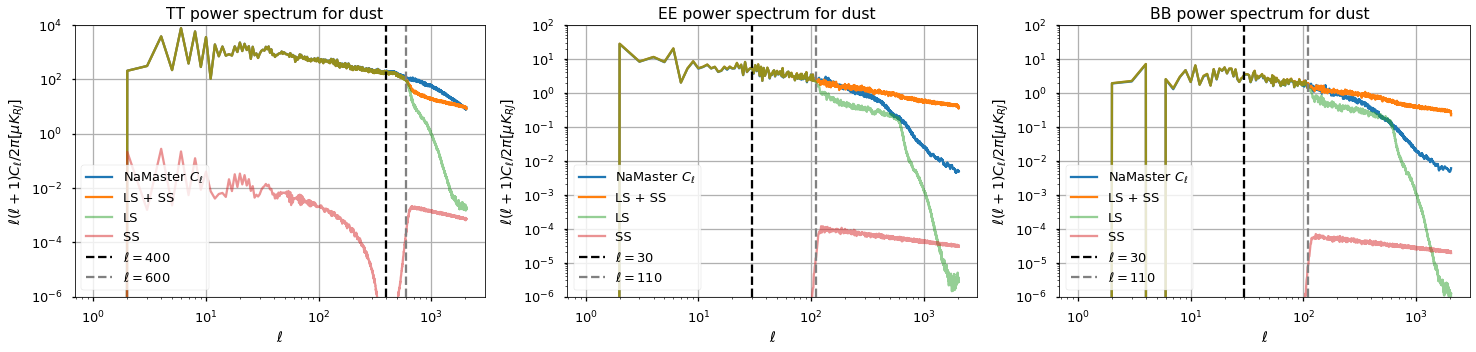

In [71]:
plt.figure(figsize=(25,5))
for ii, pol in enumerate(spectra_components):
    plt.subplot(131+ii)
    plt.loglog(ell, ell*(ell+1)/np.pi/2 * clin[pol], label="NaMaster $C_\ell$")

    plt.plot(ell, ell*(ell+1)/np.pi/2 * cloutr  [pol],label='LS + SS ')
    plt.plot(ell, ell*(ell+1)/np.pi/2 * clLSr  [pol],label='LS',alpha=.5)
    plt.plot(ell, ell*(ell+1)/np.pi/2 * clSSr  [pol],label='SS ', alpha=.5)

    plt.axvline(ell_fit_low[pol], linestyle="--", color="black", label="$ \ell={} $".format(ell_fit_low[pol]))
    plt.axvline(ell_fit_high[pol], linestyle="--", color="gray", label="$ \ell={} $".format(ell_fit_high[pol]))
    plt.legend()
    plt.grid()
    plt.title(f"{pol} power spectrum for dust  " )
    plt.ylabel("$\ell(\ell+1)C_\ell/2\pi [\mu K_{RJ}]$")
    plt.xlabel(("$\ell$"))
    #plt.ylim(1, 30);
    #plt.xlim(ell_fit_low[pol]//2 +10 , lmax)
    plt.ylim(1e-6, 1e4 if pol == "TT" else 1e2)


- In the TTspectrum of $IQU$ maps we see the mismatch already noted before, but here i plot also the spectrum of the $IQU$  map obtained by transforming  back the $iqu$ map with `LS` only. 

- We see a T->E and T->B leakage to the LS spectra post-transformation, responsible to the edges we see in BB and EE at around $\ell~600$ (  the cut-off scale of TT) 

- the mismatch we see in TT is   due to the fact that $e^{i_L} \gg  e ^{i_S}$. In fact, the spectra follow the `LS` one until the `SS` contribution  becomes more dominant at smaller scales. 

- the `SS` spectra  are produced by simply transforming back the $iqu$ maps encoding only uniform `SS` to $IQU$. They  show a mismatch in amplitude, due to the lack of information of the overall amplitude of the Galactic emission at larger scales. 

